# Here we just populate one of the eignmodes of the original LL matrix, since when you're doing just one it doesn't matter, and you can't diagonalize e12 and e23 matrices simultaneously

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [18]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

# includes a 5% enhancement for the outer pair's period ratio so not equally spaced
def eq_mass_120(seed, P12, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    # Need to give each planet e/sqrt(3) in order for e12 to equal e with pericentrs 120 degrees apart
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1, 'e':e/np.sqrt(3), 'pomega':0, 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'e':e/np.sqrt(3), 'pomega':2*np.pi/3, 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12**2, 'e':e/np.sqrt(3), 'pomega':4*np.pi/3, 'M':np.random.random()*2*np.pi}, sim=sim)
    sim.move_to_com()

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_120(params): # collision: megno = 10000, lyap = 1/10, megno nan: megno = 1000, lyap = 1/20
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1] # take 3 x the middle eigenvalue, rather than the longest which is much longer, corresponding to ecom
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

def calc_tau_max(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return tau_max(sim)

def calc_tau_max_nosec(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return tau_max(sim, sec=False)

In [19]:
def get_pool_params(xlist, ylist, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def LLeminus(sim, times, i1, i2):
    secres = sec(sim, i1, i2)
    Gx, Gy = LLsoln(secres['M'], secres['Gammax'], secres['Gammay'], times)
    Fx = secres['R'] @ Gx/secres['Lr']**(1/2)
    Fy = secres['R'] @ Gy/secres['Lr']**(1/2)
    eminus = np.sqrt(Fx[i1-1]**2 + Fy[i1-1]**2) # eminus is always in the i1 slot
    return eminus

In [20]:
def eminus_max(lsys, Lambda, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    res = {}
    res['L10'] = Lambda[i1-1]
    res['L20'] = Lambda[i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(Lambda.shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    
    Mnorm = res['R'] @ lsys.Neccentricity_matrix @ res['R'].T
    Fx0 = res['R'] @ lsys.kappa0_vec/res['Lr']**(1/2)
    Fy0 = res['R'] @ lsys.eta0_vec/res['Lr']**(1/2)

    vals,T = np.linalg.eigh(Mnorm)
    
    Ax0 = T.T @ Fx0
    Ay0 = T.T @ Fy0
    A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1])
    Fmax = np.abs(T) @ A.T
    return Fmax[i1-1] # i1-1 index is eminus for the i1,i2 pair

def calc_tau(sim, lsys, Lambda, i1, i2, sec=True):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    ps = sim.particles
    delta = (ps[i2].a-ps[i1].a)/ps[i2].a/(ps[i1].m+ps[i2].m)**(1/4)
    if sec == True:
        emax = eminus_max(lsys, Lambda, i1, i2)
    else:
        emx = ps[i2].e*np.cos(ps[i2].pomega) - ps[i1].e*np.cos(ps[i1].pomega)
        emy = ps[i2].e*np.sin(ps[i2].pomega) - ps[i1].e*np.sin(ps[i1].pomega)
        emax = np.sqrt(emx**2 + emy**2)
        
    ec = (1-(ps[i1].P/ps[i2].P)**(2/3))
    tau = 1.15/delta**2/np.abs(np.log((emax/ec)**(1/2)))**(3/2)
    return tau

def tau_max(sim, sec=True):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    pvars = Poincare.from_Simulation(sim)
    Lambda = np.array([p.Lambda for p in pvars.particles[1:]])
    
    tau_max = 0
    for i in range(1, sim.N_real):
        tau = 0
        if i-1 >= 1:
            tau += calc_tau(sim, lsys, Lambda, i-1, i, sec=sec)
        if i+1 < sim.N_real:
            tau += calc_tau(sim, lsys, Lambda, i, i+1, sec=sec)
        if tau > tau_max:
            tau_max = tau
        #print(i, tau)
    return tau_max

In [23]:
mu=1e-4
etildemax=1
tmax = None

Pmin = 1/1.05
Pmax = 1/2
NPs = 96
Nes = 32
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [14]:
sim = eq_mass_120(0, 1/1.1, 0.3, mu=mu)
tau_max(sim), tau_max(sim, sec=False)

(16.58131561889649, 10.65983717388071)

In [15]:
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
eigvals = lsys.eccentricity_eigenvalues()
Tsec = np.abs(2 * np.pi / eigvals)
tmax = Tsec[1] # take the middle eigenvalue corresponding to the ecom DOF

In [16]:
Tsec

array([  281.56397315,   570.13787411, 30308.45276487])

In [45]:
times = np.linspace(0, 5e4, 1000)
secsim = sec(sim, 1, 2)
L = secsim['Lambda']
Gx, Gy = LLsoln(secsim['M'], secsim['Gammax'], secsim['Gammay'], times)
emx12 = Gx[1]/np.sqrt(L[1]) - Gx[0]/np.sqrt(L[0])
emy12 = Gy[1]/np.sqrt(L[1]) - Gy[0]/np.sqrt(L[0])
emx23 = Gx[2]/np.sqrt(L[2]) - Gx[1]/np.sqrt(L[1])
emy23 = Gy[2]/np.sqrt(L[2]) - Gy[1]/np.sqrt(L[1])
em12 = np.sqrt(emx12**2 + emy12**2)
em23 = np.sqrt(emx23**2 + emy23**2)

[-2.40086699e-04 -1.92979321e-04  7.52848552e-05]
[-2.09307731e-04  2.70165347e-04 -7.70196344e-05]


In [46]:
ps = sim.particles
Nem12, Nem23, Nmodex, Nmodey = np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000)
for i, time in enumerate(times):
    sim.integrate(time)
    Nemx12 = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    Nemy12 = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    Nemx23 = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    Nemy23 = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    Nem12[i] = np.sqrt(Nemx12**2 + Nemy12**2)
    Nem23[i] = np.sqrt(Nemx23**2 + Nemy23**2)

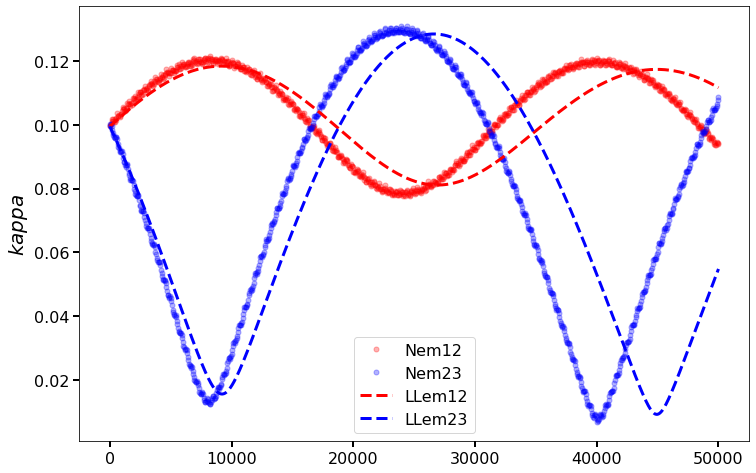

In [47]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  
#ax.plot(times,em12+em23,color='b',ls='--', label='LLsum')  
ax.set_ylabel('$kappa$')
ax.legend()
#ax.set_ylim([0,4*e])

In [36]:
calc_tau_max((0, 1/1.83, 0.3, 1e-4, 0))

0.4555307100959313

In [24]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_tau_max, params)
np.save('EqSpacing120taus.npy', results)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


CPU times: user 635 ms, sys: 1.23 s, total: 1.87 s
Wall time: 35 s


In [25]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_tau_max_nosec, params)
np.save('EqSpacing120taus_nosec.npy', results)

CPU times: user 148 ms, sys: 516 ms, total: 663 ms
Wall time: 2.83 s


In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_120, params)
np.save('EqSpacing120.npy', results)

Text(0.5, 0, '$P2/P1$')

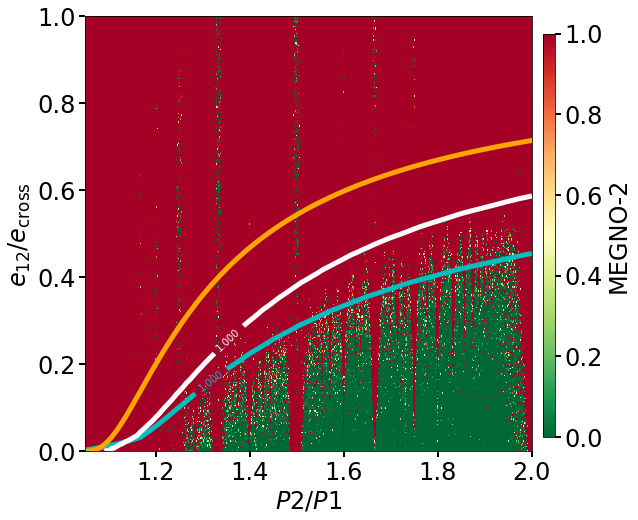

In [37]:
from matplotlib.lines import Line2D
plt.style.use('paper')

fig, ax = plt.subplots(figsize=(8,8))

mu=1e-4
etildemax=1

Pmin = 1/1.05
Pmax = 1/2
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('EqSpacing120.npy')
X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)

mu=1e-4
etildemax=1

Pmin = 1/1.05
Pmax = 1/2
NPs = 96
Nes = 32
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

tau = np.load('EqSpacing120taus.npy')
taugrid = np.array(tau).reshape(Nes,NPs)
tauX,tauY = np.meshgrid(1/P12s, etildes)

tauns = np.load('EqSpacing120taus_nosec.npy')
taugridns = np.array(tauns).reshape(Nes,NPs)

im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="RdYlGn_r")
#cb = plt.colorbar(im, ax=ax)
#cb.set_label("MEGNO-2")
ax.set_xlabel(r"$P2/P1$")
#ax.set_ylabel(r"$e/e_c$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='orange', lw=5, label='Hadden & Lithwick (2018)')

cs = ax.contour(tauX, tauY, taugrid, levels=[1], colors='c', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

cs = ax.contour(tauX, tauY, taugridns, levels=[1], colors='w', linewidths=[5])
ax.clabel(cs, inline=True, fontsize=10)

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)